In [1]:
from Data_manager.UserUtils import *
from Data_manager.split_functions.split_train_validation_random_holdout import \
    split_train_in_two_percentage_global_sample
URM_all = getURM_all()
URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.80)

In [2]:
# SETUP EVALUATORS
from Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2610 (20.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2104 (16.6%) Users that have less than 1 test interactions


In [3]:
from Recommenders.BaseRecommender import BaseRecommender

class GeneralizedMergedHybridRecommender(BaseRecommender):
    """
    This recommender merges two recommendes by weighting their ratings
    """

    RECOMMENDER_NAME = "GeneralizedMergedHybridRecommender"

    def __init__(self, URM_train, recommenders: list, verbose=True):
        self.RECOMMENDER_NAME = ''
        for recommender in recommenders:
            self.RECOMMENDER_NAME = self.RECOMMENDER_NAME + recommender.RECOMMENDER_NAME[:-11]
        self.RECOMMENDER_NAME = self.RECOMMENDER_NAME + 'HybridRecommender'

        super(GeneralizedMergedHybridRecommender, self).__init__(
            URM_train,
            verbose=verbose
        )

        self.recommenders = recommenders

    def fit(self, SLIM_Elastic_weight, RP3Beta_weight, ItemKNNCFCBF_weight, UserKNN_weight):
        self.SLIM_Elastic_weight = SLIM_Elastic_weight
        self.RP3Beta_weight = RP3Beta_weight
        self.ItemKNNCF_weight = ItemKNNCFCBF_weight
        self.UserKNN_weight = UserKNN_weight

    def save_model(self, folder_path, file_name=None):
        pass

    def _compute_item_score(self, user_id_array, items_to_compute=None):
        result = self.SLIM_Elastic_weight*self.recommenders[0]._compute_item_score(user_id_array,items_to_compute)
        result += self.RP3Beta_weight*self.recommenders[1]._compute_item_score(user_id_array,items_to_compute)
        result += self.ItemKNNCF_weight*self.recommenders[2]._compute_item_score(user_id_array,items_to_compute)
        result += self.UserKNN_weight*self.recommenders[3]._compute_item_score(user_id_array,items_to_compute)
   #     for index in range(1,len(self.alphas)):
   #         result = result + self.alphas[index]*self.recommenders[index]._compute_item_score(user_id_array,items_to_compute)
        return result


In [4]:
import os
from skopt.space import Real, Integer, Categorical
import traceback

from HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from HyperparameterTuning.SearchSingleCase import SearchSingleCase
from HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs

def runHyperparameterSearch_customHybrid(recommender_class, URM_train, recommenders, URM_train_last_test = None,
                                          n_cases = None, n_random_starts = None, resume_from_saved = False,
                                          save_model = "best", evaluate_on_test = "best", max_total_time = None,
                                          evaluator_validation = None, evaluator_test = None, evaluator_validation_earlystopping = None,
                                          metric_to_optimize = None, cutoff_to_optimize = None,
                                          output_folder_path ="result_experiments/", parallelizeKNN = True,
                                          allow_weighting = True, allow_bias_URM=False, allow_dropout_MF = False, similarity_type_list = None):
    """
    This function performs the hyperparameter optimization for a collaborative recommender
    :param recommender_class:   Class of the recommender object to optimize, it must be a BaseRecommender type
    :param URM_train:           Sparse matrix containing the URM training data
    :param URM_train_last_test: Sparse matrix containing the union of URM training and validation data to be used in the last evaluation
    :param n_cases:             Number of hyperparameter sets to explore
    :param n_random_starts:     Number of the initial random hyperparameter values to explore, usually set at 30% of n_cases
    :param resume_from_saved:   Boolean value, if True the optimization is resumed from the saved files, if False a new one is done
    :param save_model:          ["no", "best", "last"] which of the models to save, see HyperparameterTuning/SearchAbstractClass for details
    :param evaluate_on_test:    ["all", "best", "last", "no"] when to evaluate the model on the test data, see HyperparameterTuning/SearchAbstractClass for details
    :param max_total_time:    [None or int] if set stops the hyperparameter optimization when the time in seconds for training and validation exceeds the threshold
    :param evaluator_validation:    Evaluator object to be used for the validation of each hyperparameter set
    :param evaluator_validation_earlystopping:   Evaluator object to be used for the earlystopping of ML algorithms, can be the same of evaluator_validation
    :param evaluator_test:          Evaluator object to be used for the test results, the output will only be saved but not used
    :param metric_to_optimize:  String with the name of the metric to be optimized as contained in the output of the evaluator objects
    :param cutoff_to_optimize:  Integer with the recommendation list length to be optimized as contained in the output of the evaluator objects
    :param output_folder_path:  Folder in which to save the output files
    :param parallelizeKNN:      Boolean value, if True the various heuristics of the KNNs will be computed in parallel, if False sequentially
    :param allow_weighting:     Boolean value, if True it enables the use of TF-IDF and BM25 to weight features, users and items in KNNs
    :param allow_bias_URM:      Boolean value, if True it enables the use of bias to shift the values of the URM
    :param allow_dropout_MF:    Boolean value, if True it enables the use of dropout on the latent factors of MF algorithms
    :param similarity_type_list: List of strings with the similarity heuristics to be used for the KNNs
    """



    # If directory does not exist, create
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    earlystopping_keywargs = {"validation_every_n": 5,
                              "stop_on_validation": True,
                              "evaluator_object": evaluator_validation_earlystopping,
                              "lower_validations_allowed": 5,
                              "validation_metric": metric_to_optimize,
                              }

    URM_train = URM_train.copy()
    recommenders = recommenders.copy()

    n_users, n_items = URM_train.shape

    if URM_train_last_test is not None:
        URM_train_last_test = URM_train_last_test.copy()

    try:

        output_file_name_root = recommender_class.RECOMMENDER_NAME

        hyperparameterSearch = SearchBayesianSkopt(recommender_class, evaluator_validation=evaluator_validation, evaluator_test=evaluator_test)
    
       ##########################################################################################################

        if recommender_class is GeneralizedMergedHybridRecommender:

            hyperparameters_range_dictionary = {
                "SLIM_Elastic_weight": Real(low = 0, high = 2, prior = 'uniform'),
                "RP3Beta_weight": Real(low = 0, high = 2, prior = 'uniform'),
                "ItemKNNCF_weight": Real(low = 0, high = 2, prior = 'uniform'),
                "UserKNNCF_weight": Real(low = 0, high = 2, prior = 'uniform'),
            }

            recommender_input_args = SearchInputRecommenderArgs(
                CONSTRUCTOR_POSITIONAL_ARGS = [URM_train, recommenders],
                CONSTRUCTOR_KEYWORD_ARGS = {},
                FIT_POSITIONAL_ARGS = [],
                FIT_KEYWORD_ARGS = {},
                EARLYSTOPPING_KEYWORD_ARGS = {},
            )

       #########################################################################################################

        if URM_train_last_test is not None:
            recommender_input_args_last_test = recommender_input_args.copy()
            recommender_input_args_last_test.CONSTRUCTOR_POSITIONAL_ARGS[0] = URM_train_last_test
        else:
            recommender_input_args_last_test = None

        ## Final step, after the hyperparameter range has been defined for each type of algorithm
        hyperparameterSearch.search(recommender_input_args,
                               hyperparameter_search_space= hyperparameters_range_dictionary,
                               n_cases = n_cases,
                               n_random_starts = n_random_starts,
                               resume_from_saved = resume_from_saved,
                               save_model = save_model,
                               evaluate_on_test = evaluate_on_test,
                               max_total_time = max_total_time,
                               output_folder_path = output_folder_path,
                               output_file_name_root = output_file_name_root,
                               metric_to_optimize = metric_to_optimize,
                               cutoff_to_optimize = cutoff_to_optimize,
                               recommender_input_args_last_test = recommender_input_args_last_test)




    except Exception as e:

        print("On recommender {} Exception {}".format(recommender_class, str(e)))
        traceback.print_exc()

        error_file = open(output_folder_path + "ErrorLog.txt", "a")
        error_file.write("On recommender {} Exception {}\n".format(recommender_class, str(e)))
        error_file.close()

2023-11-20 23:38:48.453950: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 23:38:49.106914: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 23:38:49.110291: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 23:38:52.233106: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
SLIM_Elastic = SLIMElasticNetRecommender(URM_train)
RP3Beta = RP3betaRecommender(URM_train)
ItemKNNCF = ItemKNNCFRecommender(URM_train)
UserKNNCF = UserKNNCFRecommender(URM_train)

SLIM_Elastic.load_model("result_experiments/", "SLIMElasticNetRecommender_best_model.zip")
RP3Beta.load_model("result_experiments/", "RP3betaRecommender_best_model.zip")
ItemKNNCF.load_model("result_experiments/", "ItemKNNCFRecommender_cosine_best_model.zip")
UserKNNCF.load_model("result_experiments/", "UserKNNCFRecommender_cosine_best_model.zip")

SLIMElasticNetRecommender: URM Detected 433 ( 3.4%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 327 ( 1.5%) items with no interactions.
RP3betaRecommender: URM Detected 433 ( 3.4%) users with no interactions.
RP3betaRecommender: URM Detected 327 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 433 ( 3.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 327 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 433 ( 3.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 327 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIMElasticNetRecommender_best_model.zip'
SLIMElasticNetRecommender: Loading complete
RP3betaRecommender: Loading model from file 'result_experiments/RP3betaRecommender_best_model.zip'
RP3betaRecommender: Loading complete
ItemKNNCFRecommender: Loading model from file 'result_experiments/ItemKNNCFRecommender_cosine_best_mo

In [ ]:
recommenders = [SLIM_Elastic, RP3Beta, ItemKNNCF, UserKNNCF] # ORDER MATTER!!!!!!!!!

from functools import partial

output_folder_path = "result_experiments/SKOPT_test/"

n_cases = 300
n_random_starts = int(n_cases * 0.25)

runHyperparameterSearch_customHybrid_partial = partial(
                    runHyperparameterSearch_customHybrid,
                    URM_train = URM_train,
                    recommenders = recommenders,
                    URM_train_last_test = URM_train_validation,
                    metric_to_optimize = "MAP",
                    cutoff_to_optimize = 10,
                    n_cases = n_cases,
                    n_random_starts = n_random_starts,
                    evaluator_validation_earlystopping = evaluator_validation,
                    evaluator_validation = evaluator_validation,
                    evaluator_test = evaluator_test,
                    output_folder_path = output_folder_path,
                    resume_from_saved = False
)

runHyperparameterSearch_customHybrid_partial(GeneralizedMergedHybridRecommender)

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'SLIM_Elastic_weight': 0.11329363784054694, 'RP3Beta_weight': 1.8928551501420416, 'ItemKNNCFCBF_weight': 1.8054638000169703, 'UserKNN_weight': 0.9835092142390605}
SLIMElasticNetRP3betaItemKNNCFUserKNNCFHybridRecommender: URM Detected 462 ( 3.7%) users with no interactions.
SLIMElasticNetRP3betaItemKNNCFUserKNNCFHybridRecommender: URM Detected 334 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10047 (100.0%) in 12.77 sec. Users per second: 787
SearchBayesianSkopt: New best config found. Config 0: {'SLIM_Elastic_weight': 0.11329363784054694, 'RP3Beta_weight': 1.8928551501420416, 'ItemKNNCFCBF_weight': 1.8054638000169703, 'UserKNN_weight': 0.9835092142390605} - results: PRECISION: 0.0417239, PRECISION_RECALL_MIN_DEN: 0.1071092, RECALL: 0.1016870, MAP: 0.0229525, MAP_MIN_DEN: 0.0664835, MRR: 0.1947299, NDCG: 0.1035566, F1: 0.0591695, HIT_RATE: 0.3428884, ARHR_ALL_HITS: 0.211

In [3]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
profile_length, profile_length.shape

(array([27, 30,  3, ...,  0, 16, 50], dtype=int32), (12638,))

In [4]:
block_size = int(len(profile_length)*0.2)
block_size

2527

In [5]:
sorted_users = np.argsort(profile_length)
for group_id in range(0, 5):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    

Group 0, #users in group 2527, average p.len 1.23, median 1.0, min 0, max 3
Group 1, #users in group 2527, average p.len 4.86, median 5.0, min 3, max 8
Group 2, #users in group 2527, average p.len 11.78, median 12.0, min 8, max 17
Group 3, #users in group 2527, average p.len 25.46, median 25.0, min 17, max 37
Group 4, #users in group 2527, average p.len 77.18, median 61.0, min 37, max 449


In [9]:
from Hybrid import *
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.FactorizationMachines.LightFMRecommender import LightFMCFRecommender
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_AsySVD_Cython
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "UserKNNCF": UserKNNCFRecommender,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   #"P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "PureSVD": PureSVDRecommender,
                                   #"NMF": NMFRecommender,
                                   #"BPR": MatrixFactorization_BPR_Cython,
                                   "SLIM_ELASTIC": SLIMElasticNetRecommender,
                                   #"LightFM": LightFMCFRecommender,
                                   "IALS": IALSRecommender,
                                   "EASE_R": EASE_R_Recommender,
                                   "HYBRID": HybridRecommender
                                   }
collaborative_recommender_class.items()

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train_validation)
    recommender_object_dict[label] = recommender_object
    
    
recommender_object_dict["TopPop"].load_model("result_experiments_old/", "TopPopRecommender_best_model.zip")
recommender_object_dict["SLIM_ELASTIC"].fit(topK=8894, l1_ratio=0.05565733019999427, alpha=0.0012979360257937668)
recommender_object_dict["PureSVD"].load_model("result_experiments_old/", "PureSVDRecommender_best_model.zip")
#recommender_object_dict["NMF"].load_model("result_experiments/", "NMFRecommender_best_model.zip")
#recommender_object_dict["P3alpha"].load_model("result_experiments/", "P3alphaRecommender_best_model.zip")
recommender_object_dict["RP3beta"].load_model("result_experiments_old/", "RP3betaRecommender_best_model.zip")
recommender_object_dict["UserKNNCF"].load_model("result_experiments_old/", "UserKNNCFRecommender_cosine_best_model.zip")
recommender_object_dict["ItemKNNCF"].load_model("result_experiments_old/", "ItemKNNCFRecommender_cosine_best_model.zip")
#recommender_object_dict["BPR"].load_model("result_experiments/", "MatrixFactorization_BPR_Cython_Recommender_best_model.zip")
#recommender_object_dict["LightFM"].load_model("result_experiments/", "LightFMCFRecommender_best_model.zip")
recommender_object_dict["IALS"].load_model("result_experiments_old/", "IALSRecommender_best_model.zip")
recommender_object_dict["EASE_R"].load_model("result_experiments_old/", "EASE_R_Recommender_best_model.zip")
recommender_object_dict["HYBRID"].fit()
from Hybrid import LinearHybridRecommender
#recommenders = [SLIM_Elastic, RP3Beta, ItemKNNCF, UserKNNCF] # ORDER MATTER!!!!!!!!!

#alphas = [0.6321191861151624, 1.390285841050952, 0.23173069155212617, 0.0031112219228564527]

#recommender_object_dict["HYBRID"] = LinearHybridRecommender(URM_train, recommenders)
#recommender_object_dict["HYBRID"].fit(alphas)

TopPopRecommender: URM Detected 228 ( 1.8%) users with no interactions.
TopPopRecommender: URM Detected 108 ( 0.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 228 ( 1.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 108 ( 0.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 228 ( 1.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 108 ( 0.5%) items with no interactions.
RP3betaRecommender: URM Detected 228 ( 1.8%) users with no interactions.
RP3betaRecommender: URM Detected 108 ( 0.5%) items with no interactions.
PureSVDRecommender: URM Detected 228 ( 1.8%) users with no interactions.
PureSVDRecommender: URM Detected 108 ( 0.5%) items with no interactions.
SLIMElasticNetRecommender: URM Detected 228 ( 1.8%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 108 ( 0.5%) items with no interactions.
IALSRecommender: URM Detected 228 ( 1.8%) users with no interactions.
IALSRecommender: URM Detected 108 

In [10]:
from Evaluation.Evaluator import EvaluatorHoldout

MAP_recommender_per_group = {}
cutoff = 10

for group_id in range(0, 5):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
        

Group 0, #users in group 2527, average p.len 1.23, median 1.0, min 0, max 3
EvaluatorHoldout: Ignoring 2104 (16.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 10111 Users
EvaluatorHoldout: Processed 1133 (100.0%) in 1.04 sec. Users per second: 1088
EvaluatorHoldout: Processed 1133 (100.0%) in 1.10 sec. Users per second: 1030
EvaluatorHoldout: Processed 1133 (100.0%) in 0.74 sec. Users per second: 1530
EvaluatorHoldout: Processed 1133 (100.0%) in 0.79 sec. Users per second: 1425
EvaluatorHoldout: Processed 1133 (100.0%) in 0.94 sec. Users per second: 1205
EvaluatorHoldout: Processed 1133 (100.0%) in 0.81 sec. Users per second: 1392
EvaluatorHoldout: Processed 1133 (100.0%) in 0.99 sec. Users per second: 1147
EvaluatorHoldout: Processed 1133 (100.0%) in 0.91 sec. Users per second: 1243
EvaluatorHoldout: Processed 1133 (100.0%) in 1.11 sec. Users per second: 1023
Group 1, #users in group 2527, average p.len 4.86, median 5.0, min 3, max 8
EvaluatorHoldout: Ign

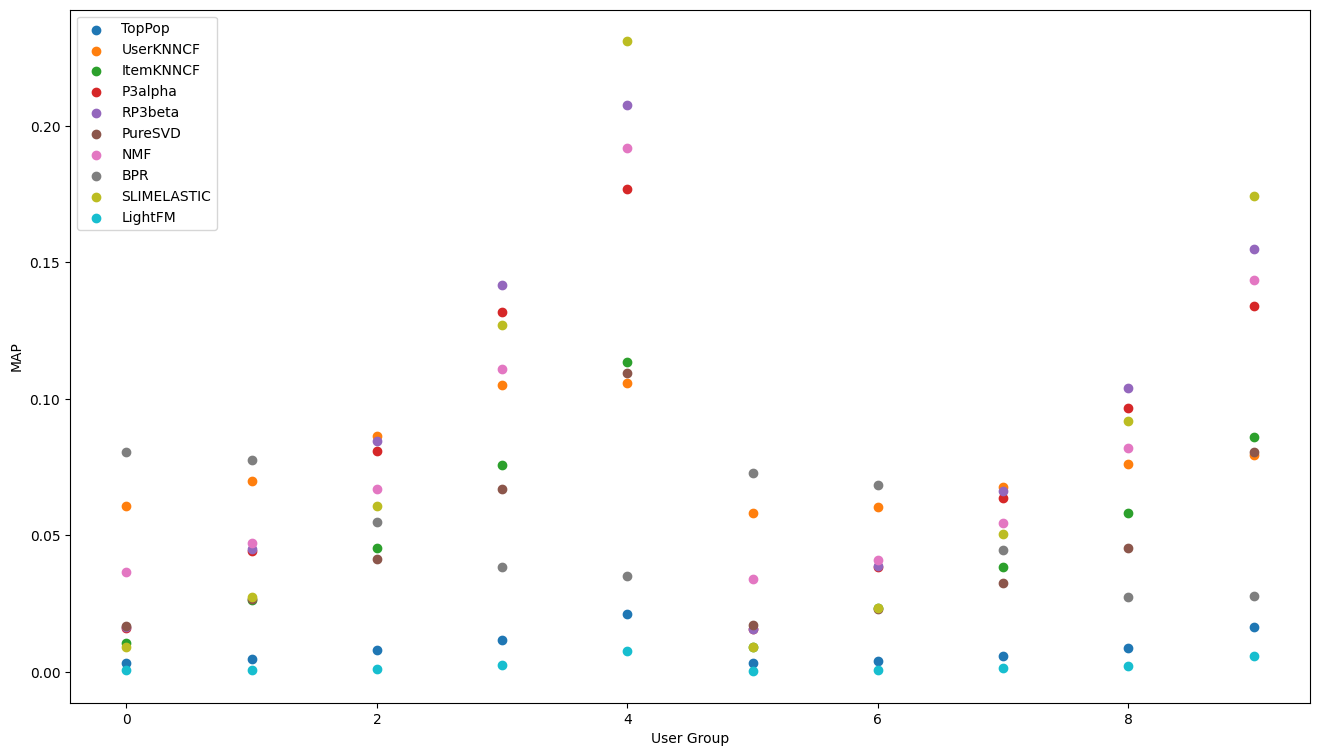

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

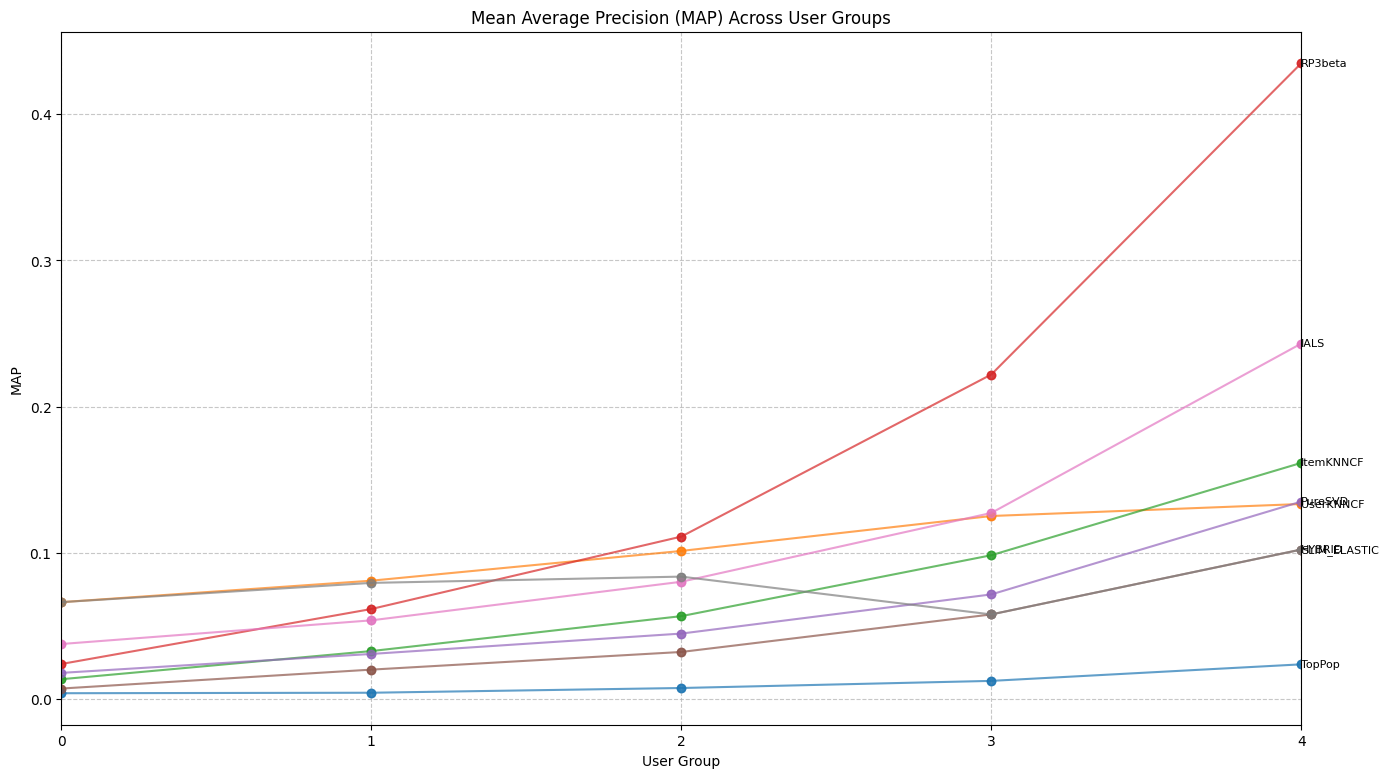

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have the following data structure
# recommender_object_dict = {'Recommender1': recommender1, 'Recommender2': recommender2, ...}
# MAP_recommender_per_group = {'Recommender1': [0.8, 0.7, 0.6, ...], 'Recommender2': [0.9, 0.8, 0.7, ...], ...}

# Your original code
_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label, alpha=0.7)

# Modifications for a better plot
plt.title('Mean Average Precision (MAP) Across User Groups')
plt.xlabel('User Group')
plt.ylabel('MAP')

# Use a line plot for better trend visualization
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.plot(np.arange(0, len(results)), results, marker='o', linestyle='-', alpha=0.7)
    
    # Annotate the lines with the names of the recommender systems
    last_value = results[-1]
    plt.text(len(results)-1, last_value, label, ha='left', va='center', fontsize=8)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis ticks to integers from 0 to 4
plt.xticks(np.arange(0, 5))

# Set x-axis limits to 0 and 4
plt.xlim(0, 4)

plt.show()

In [2]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Hybrid import HybridRecommender
recommender = HybridRecommender(URM_all)
recommender.fit()
top_recommender = TopPop(URM_all)
top_recommender.fit()

SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIMElasticNetRecommender_best_model.zip'
SLIMElasticNetRecommender: Loading complete
RP3betaRecommender: Loading model from file 'result_experiments/RP3betaRecommender_best_model.zip'
RP3betaRecommender: Loading complete
UserKNNCFRecommender: Loading model from file 'result_experiments/UserKNNCFRecommender_cosine_best_model.zip'
UserKNNCFRecommender: Loading complete


In [6]:
generateSubmission(recommender, top_recommender)

In [5]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
recommender = IALSRecommender(URM_all)
recommender.load_model("result_experiments/", "IALSRecommender_best_model.zip")
top_recommender = TopPop(URM_all)
top_recommender.fit()

IALSRecommender: Loading model from file 'result_experiments/IALSRecommender_best_model.zip'
IALSRecommender: Loading complete
